In [4]:
import pandas as pd
from sklearn.linear_model import GammaRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_gamma_deviance
pd.set_option('display.max_rows', 500)


## Loading data

<AxesSubplot:>

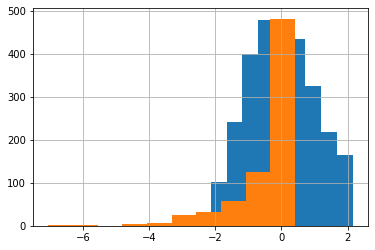

In [20]:
path2021 = "../data/uefa-data/processed/2021_"
path2020 = "../data/uefa-data/processed/2020_"

playerStats = pd.read_csv(path2021 + "player_stats.csv")
defense = pd.read_csv(path2021 + "defense.csv")
goalkeeping = pd.read_csv(path2021 + "goalkeeping.csv")
passing = pd.read_csv(path2021 + "passing.csv")
shooting = pd.read_csv(path2021 + "shooting.csv")
mv2020 = pd.read_csv(path2020+ "mv.csv")


ok = mv2020.merge(playerStats, left_on ="fbref id", right_on = "Player")
print()
ok.drop(columns = "fbref id").to_csv("player.csv")


defense = playerStats.merge(defense, on = "Player")
goalkeeping = playerStats.merge(goalkeeping, on = "Player")
passing = playerStats.merge(passing, on = "Player")
shooting = playerStats.merge(shooting, on = "Player")

path = "../data/processed-data/"

raritaDf = pd.read_csv(path + "l_defense_clean.csv", index_col = 0)
raritaPs = pd.read_csv(path + "l_passing_clean.csv", index_col = 0)
raritaGk = pd.read_csv(path + "l_goalkeeping_clean.csv", index_col = 0)
raritaSh = pd.read_csv(path + "l_shooting_clean.csv", index_col = 0)
salary2020 = pd.read_csv(path + "salary_2020.csv", index_col = 0)
salary2021 = pd.read_csv(path + "salary_2021.csv", index_col = 0)


salary2021["Annualized Salary"] = salary2021["Annualized Salary"]*1.141
salarymean = salary2021["Annualized Salary"].mean()
salaryvar = salary2021["Annualized Salary"].var()
mvmean = playerStats["mv"].median()
mvvar = playerStats["mv"].var()


salary2021["Annualized Salary"] = (salarymean-salary2021["Annualized Salary"])/np.sqrt(salaryvar)
playerStats["mv"] = (mvmean-playerStats["mv"])/np.sqrt(mvvar)


salary2021["Annualized Salary"].hist()

playerStats["mv"].hist()



## Data exploration

Index(['Player', 'Age', '90s', 'mv', 'DF', 'FW', 'GK', 'MF', 'Tota Cmp',
       'Tota Att', 'Tota Cmp%', 'Tota TotDist', 'Tota PrgDist', 'Shor Cmp',
       'Shor Att', 'Shor Cmp%', 'Medi Cmp', 'Medi Att', 'Medi Cmp%',
       'Long Cmp', 'Long Att', 'Long Cmp%', 'Ast', 'xA', 'A-xA', 'KP', '1/3',
       'PPA', 'CrsPA', 'Prog'],
      dtype='object')


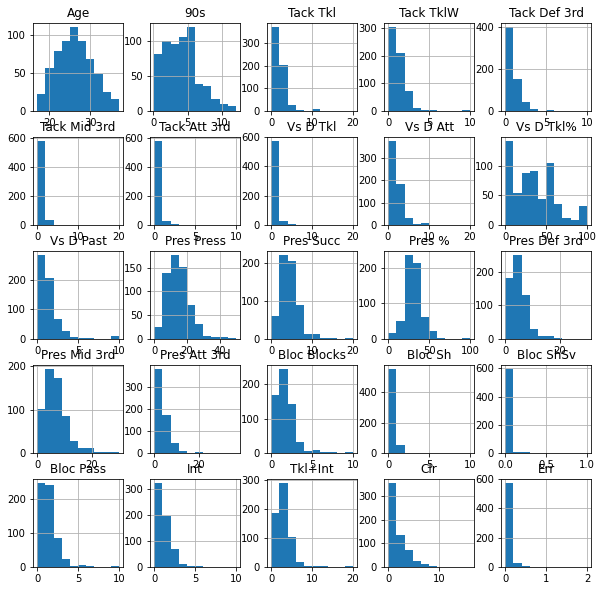

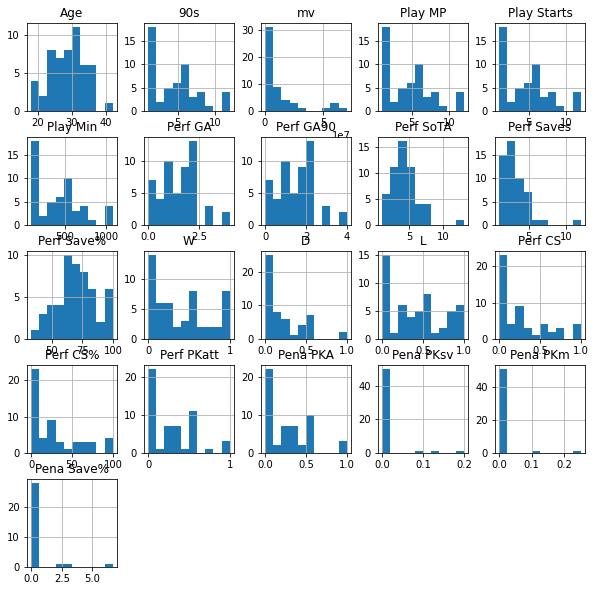

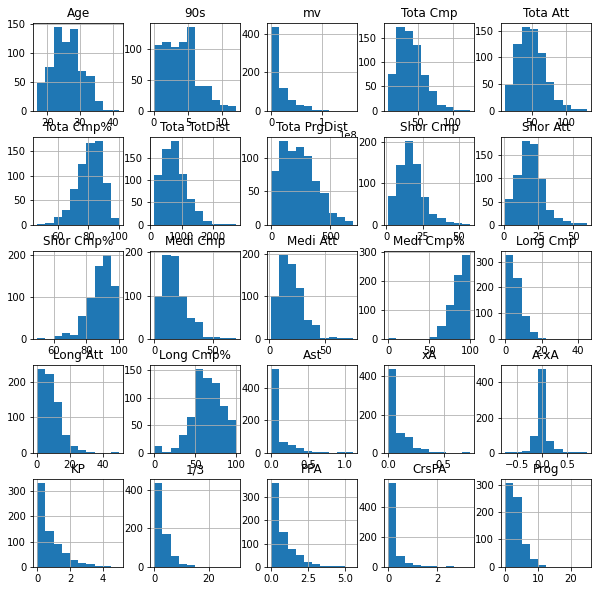

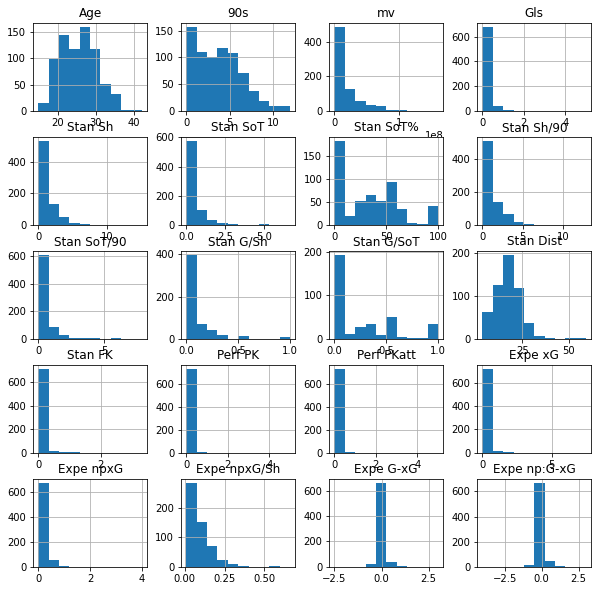

In [6]:

#salary2020.hist(column = "Annualized Salary", bins = 20)
#salary2021.hist(column = "Annualized Salary", bins = 20)

print(passing.columns)

defense.dropna()[['Player', 'Age', '90s', 'Tack Tkl',
       'Tack TklW', 'Tack Def 3rd', 'Tack Mid 3rd', 'Tack Att 3rd', 'Vs D Tkl',
       'Vs D Att', 'Vs D Tkl%', 'Vs D Past', 'Pres Press', 'Pres Succ',
       'Pres %', 'Pres Def 3rd', 'Pres Mid 3rd', 'Pres Att 3rd', 'Bloc Blocks',
       'Bloc Sh', 'Bloc ShSv', 'Bloc Pass', 'Int', 'Tkl+Int', 'Clr', 'Err']].hist(figsize=(10,10))
goalkeeping.drop(columns = ["GK", "MF", "DF", "FW"]).hist(figsize=(10,10))
passing.drop(columns = ["GK", "MF", "DF", "FW"]).dropna().hist(figsize=(10,10))
shooting.drop(columns = ["GK", "MF", "DF", "FW"]).hist(figsize=(10,10))


defense.to_csv("df.csv")

def plotFeatures(data): 
    X = data.iloc[:,8:]  #independent columns
    y = data.iloc[:,4]    #target column i.e price range
    #get correlations of each features in dataset
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(method = "kendall"),annot=True,cmap="RdYlGn")

#plotFeatures(defense)
#plotFeatures(goalkeeping)
#plotFeatures(passing)
#plotFeatures(shooting)

## Data cleaning

In [7]:

# These are all the 'important' features from visually inspecting the correlation heatmap
df = defense.loc[defense["DF"] == 1]
df = df[["mv",  "Age", "90s", "Tack Tkl", "Tack TklW", "Tack Mid 3rd", "Tack Att 3rd", "Vs D Tkl", "Vs D Past", "Pres Succ", "Pres Mid 3rd", "Bloc Sh", "Bloc Pass", "Int"]]

sh = shooting.loc[shooting["FW"] == 1]
sh = sh[["mv",  "Age", "90s", "Gls", "Stan Sh", "Stan SoT", "Stan G/Sh", "Stan FK", "Perf PK", "Perf PKatt", "Expe xG", "Expe npxG", "Expe npxG/Sh"]]

gk = goalkeeping.loc[goalkeeping["GK"] == 1]
gk = gk[["mv", "Age", "90s", "Play MP", "Play Starts",  "Perf GA", "Perf SoTA", "W", "Perf CS", "Perf CS%", "Pena PKA"]]

ps = passing.loc[passing["MF"] == 1]
ps = ps[["mv", "Age", "90s", "Tota Cmp", "Tota Att", "Tota TotDist", "Shor Cmp", "Shor Att", "Long Cmp%", "Ast", "xA", "KP", "1/3", "PPA", "CrsPA", "Prog"]]
ps["Tota TotDist"] = ps["Tota TotDist"]/100

def remove_empty_rows(df: pd.DataFrame):
    # threshold for zero
    threshold = 0.1

    num = len(df.columns) - 3

    for i, row in df.iterrows():
        count = 0
        for j in row[3:]:
            if ((j < threshold or pd.isna(j))):
                count += 1

        if (count / num > 0.8):
            df = df.drop(i)
    return df;

sh = remove_empty_rows(sh)
df = remove_empty_rows(df)
ps = remove_empty_rows(ps)
gk = remove_empty_rows(gk)

df = df.dropna()
ps = ps.dropna()
sh = sh.dropna()
gk = gk.dropna()


In [ ]:
raritaDf = raritaDf.loc[raritaDf["Year"] == 2021]
raritaSh = raritaSh.loc[raritaSh["Year"] == 2021]
raritaGk = raritaGk.loc[raritaGk["Year"] == 2021]
raritaPs = raritaPs.loc[raritaPs["Year"] == 2021]

print(raritaDf.columns)

raritaDf = raritaDf.loc[raritaDf["DF"] == 1]
raritaDf = raritaDf[["Player","Squad","Age", "90s", "Tackles Tkl", "Tackles TklW", "Tackles Mid 3rd", "Tackles Att 3rd", "Vs Dribbles Tkl", "Vs Dribbles Past", "Pressures Succ", "Pressures Mid 3rd", 'Blocks Sh', "Blocks Pass", "Int"]]

raritaSh = raritaSh.loc[raritaSh["FW"] == 1]
raritaSh = raritaSh[["Player","Squad","Age", "90s", "Gls", "Standard Sh", "Standard SoT", "Standard G/Sh", "Standard FK", "Performance PK", "Performance PKatt", "Expected xG", "Expected npxG", "Expected npxG/Sh"]]

raritaGk = raritaGk.loc[raritaGk["GK"] == 1]
raritaGk = raritaGk[["Player","Squad","Age", "Playing Time 90s", "Playing Time MP", "Playing Time Starts",  "Performance GA", "Performance SoTA", "W", "Performance CS", "Performance CS%", "Penalty Kicks PKA"]]
raritaGk = raritaGk.rename(columns={"Playing Time 90s": "90s"})

raritaPs = raritaPs.loc[raritaPs["MF"] == 1]
raritaPs = raritaPs[["Player","Squad", "Age", "90s", "Total Cmp", "Total Att", "Total TotDist", "Short Cmp", "Short Att", "Long Cmp%", "Ast", "xA", "KP", "1/3", "PPA", "CrsPA", "Prog", "League"]]
raritaPs["Total TotDist"] = raritaPs["Total TotDist"]/100


# process all negatives
#for i, s in raritaDf.drop(columns = ["Player","Squad"]).iteritems():
    #print(i, len(s[s < -0])/len(s), len(s[s < -0.1])/len(s))




Index(['Player', 'Nation', 'FW', 'MF', 'DF', 'GK', 'Squad', 'Age', 'Born',
       '90s', 'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd',
       'Tackles Mid 3rd', 'Tackles Att 3rd', 'Vs Dribbles Tkl',
       'Vs Dribbles Att', 'Vs Dribbles Tkl%', 'Vs Dribbles Past',
       'Pressures Press', 'Pressures Succ', 'Pressures %', 'Pressures Def 3rd',
       'Pressures Mid 3rd', 'Pressures Att 3rd', 'Blocks Blocks', 'Blocks Sh',
       'Blocks ShSv', 'Blocks Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'League',
       'Year'],
      dtype='object')


In [ ]:
# Converting rows into per 90 values as they seem to not be converted...
problem = raritaPs.loc[(raritaPs["League"] == "D") | (raritaPs["Squad"] == "Black Coyotes") | (raritaPs["Squad"] == "Serious Buffaloes") | (raritaPs["Squad"] == "Strong Oaks")]
convert = problem.columns.difference(["Player", "Squad","Age", "90s", "Long Cmp%", "League"])
problem[convert] = problem[convert].div(problem["90s"], axis = 0).round(decimals = 2)
raritaPs.loc[(raritaPs["League"] == "D") | (raritaPs["Squad"] == "Black Coyotes") | (raritaPs["Squad"] == "Serious Buffaloes") | (raritaPs["Squad"] == "Strong Oaks")] = problem

raritaPs = raritaPs.drop(columns = "League")
# raritaPs.boxplot(figsize = (10,10))



In [ ]:
# join salary for visualisation later
def joinSalary(frame):
    frame = frame.dropna()
    frame = pd.merge(frame, salary2021[["Player Name", "Squad", "Annualized Salary"]], right_on = ["Player Name", "Squad"], left_on=["Player", "Squad"])
    return frame.drop(columns = "Player Name")

raritaPs = joinSalary(raritaPs)
raritaGk = joinSalary(raritaGk)
raritaSh = joinSalary(raritaSh)
raritaDf = joinSalary(raritaDf)



## Building model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gammaregressor', GammaRegressor(max_iter=1000))])

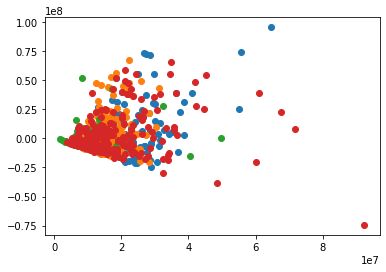

In [ ]:

def fitModel(data):
    # make train + test split
    X = data.drop(columns = ["mv"])
    y = data["mv"]

    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 114514)

    model = make_pipeline(StandardScaler(), GammaRegressor(max_iter=1000))
    model.fit(XTrain, yTrain)

    plt.scatter(x= model.predict(XTrain), y =yTrain-model.predict(XTrain))
    
    yPred = model.predict(XTest)
    return model

import warnings
warnings.filterwarnings('ignore') 

def showFit(data, raritaData):
    model = fitModel(data)
    predMV  =1.141*model.predict(raritaData.dropna().drop(columns = ["Player", "Squad","Annualized Salary"]))

    frame = pd.concat([raritaData.dropna(), pd.Series(predMV)], axis = 1)
    frame = pd.DataFrame(frame)
    frame.plot.scatter(x = "Pred MV", y = "Salary")

fitModel(sh)
fitModel(df)
fitModel(gk)
fitModel(ps)

#showFit(df, raritaDf)
#showFit(sh, raritaSh)
#showFit(gk, raritaGk)
#showFit(ps, raritaPs)



